In [38]:
import numpy as np
import pickle
from skimage import filters
from PIL import Image
import glob as glob
import matplotlib.pyplot as plt
import torch as torch
import os

In [51]:
testimage = [np.array(Image.open(path)) for path in glob.glob("test_imgs/*.jpg")]
testlabel = [np.array(Image.open(path)) for path in glob.glob("test_imgs/*.png")]

In [6]:
def reg_blur(label = None, threshold = 0.25):
    if label is None: return 1
    if type(label) is not np.ndarray: return 1
    blur = filters.gaussian(label,10,multichannel=True)
    print(np.amax(blur))
    return np.where(np.divide(blur,np.amax(blur))>threshold,1,0)

In [9]:
def noisy_blur(label = None, threshold = 0.25, noise = .25, noise_kernels = 10):
    if label is None: return 1
    if type(label) is not np.ndarray: return 1
    blur = filters.gaussian(label,10,multichannel=True)
    noisetensor = torch.normal(0,1,size=(1,1,noise_kernels,noise_kernels))
    noisetensor = torch.nn.functional.interpolate(noisetensor, size = (len(blur[0]),len(blur[1])), mode = 'bilinear', align_corners = False)
    noisetensor = np.array(noisetensor.permute(2,3,1,0)[:,:,:,0])
    noisetensor = np.divide(noisetensor,np.amax(np.array(noisetensor)))*np.amax(blur)*noise
    blur = blur+noisetensor
    return np.where(np.divide(blur,np.amax(blur))>threshold,1,0)

0.0033054815950608173


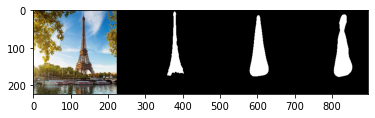

0.003561674289555073


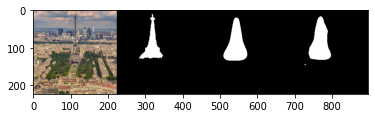

0.0020697942376571685


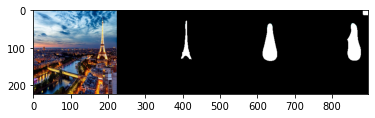

0.002327025233665738


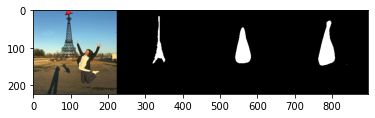

0.003574287136520723


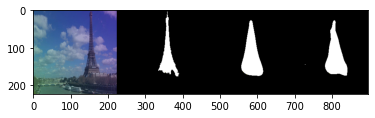

In [10]:
for i in range(len(testimage)):
    quouble = np.hstack((testimage[i], testlabel[i]*255, reg_blur(testlabel[i])*255, noisy_blur(testlabel[i])*255))
    plt.imshow(quouble)
    plt.show()


In [52]:
testim = testimage[0]
testla = testlabel[0]

In [94]:
input_image = np.concatenate((testim,noisy_blur(testla)[:,:,0:1]), axis=2)
gt_image = np.concatenate((testla,testla), axis = 2)[:,:,0:4]
combined = np.hstack((input_image,gt_image))

(224, 224, 1)

In [39]:
in_directory = 'test_imgs'
out_directory = 'out_labels'

for path in glob.glob(f'{in_directory}/*.png'):
    outname = os.path.basename(path)
    
    print(path)
    
    
    image = np.array(Image.open(path))
    
    input_image = np.concatenate((testim,noisy_blur(testla)[:,:,0:1]), axis=2)
    gt_image = np.concatenate((testla,testla), axis = 2)[:,:,0:4]
    combined = np.hstack((input_image,gt_image))
    
    
    result = Image.fromarray(noisy_blur(image).astype('uint8'), 'RGB')
    result.save(f'{out_directory}/{outname}')